# Импорты

In [1]:
import pickle

import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output

from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric_temporal.signal import DynamicHeteroGraphTemporalSignal

# Загрузка и первичный обзор данных

In [2]:
data = pd.read_csv("train_test_data/train_data.csv")

d = {
    "НЕФ": "P",
    "НАГ": "I",
}
data["CHARWORK"] = data["CHARWORK"].map(d)
data["MEASURED_IN_DATE"] = pd.to_datetime(data["MEASURED_IN_DATE"])
data = data.drop(["MEASURED_IN", "KCHARWORK"], axis=1)

print(data.shape)
display(data.head())

(177575, 9)


,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,IS_WORKING
0,2017-02-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
1,2017-02-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
2,2017-02-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
3,2017-02-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
4,2017-02-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True


In [3]:
data.describe()

,MEASURED_IN_DATE,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE
count,177575,177575.000000,177575.000000,166194.000000,177575.000000,50393.000000
mean,2020-11-08 21:58:36.271997440,232.797567,25.001408,80.846916,160.055048,124.874784
min,2016-08-02 00:00:00,0.000000,0.000000,4.380000,0.000000,10.000000
25%,2020-03-17 00:00:00,0.000000,0.000000,52.522500,0.000000,115.000000
50%,2021-03-17 00:00:00,129.000000,9.000000,66.510000,0.000000,138.000000
75%,2021-10-24 00:00:00,348.000000,46.000000,95.390000,183.000000,148.000000
max,2022-05-31 00:00:00,1622.000000,99.900000,276.940000,1775.000000,180.000000
std,NaN,289.178515,30.567793,43.104905,305.891882,35.849217


In [4]:
print(f'Количество скважин: {len(data["WELL_NAME"].unique())}')

Количество скважин: 266


In [5]:
print("Количество скважин каждой группы:")
tmp = data.drop_duplicates(subset=["WELL_NAME", "CHARWORK"])
tmp.groupby("CHARWORK").agg({"WELL_NAME": "count"})

Количество скважин каждой группы:


,WELL_NAME
CHARWORK,
I,61
P,257


## Визуализация профилей добычи

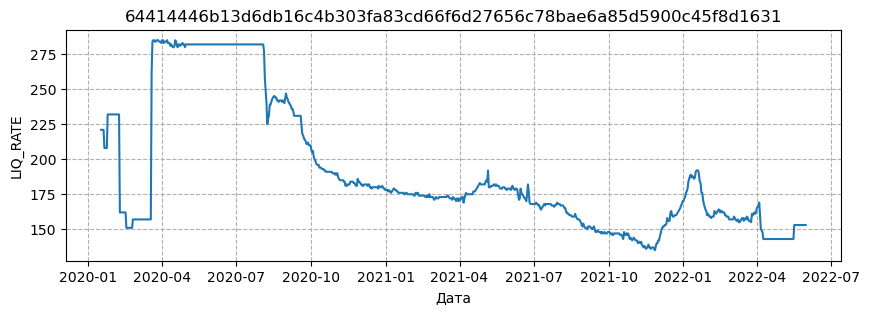

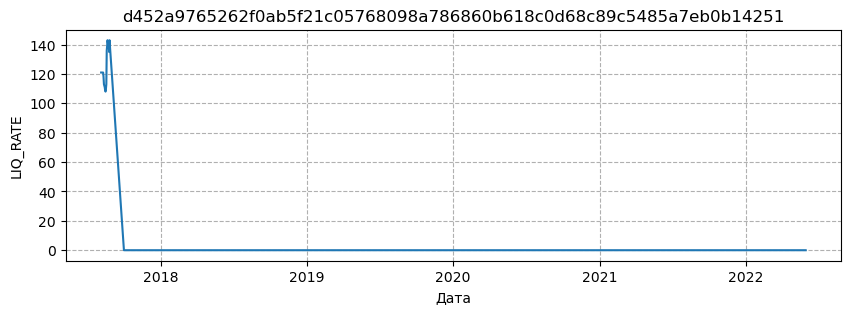

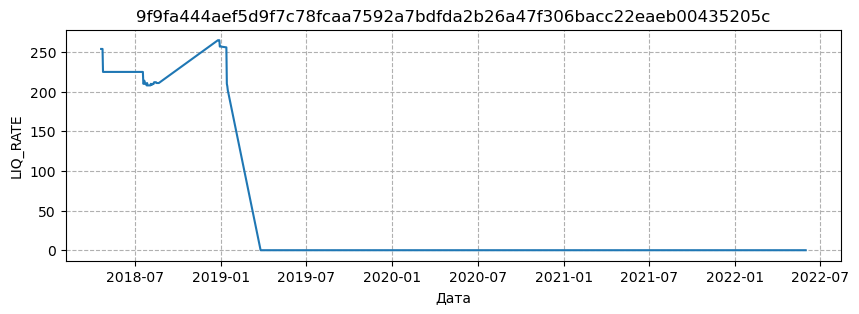

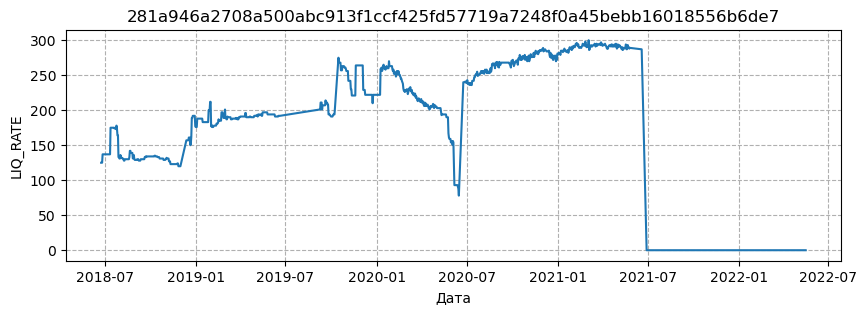

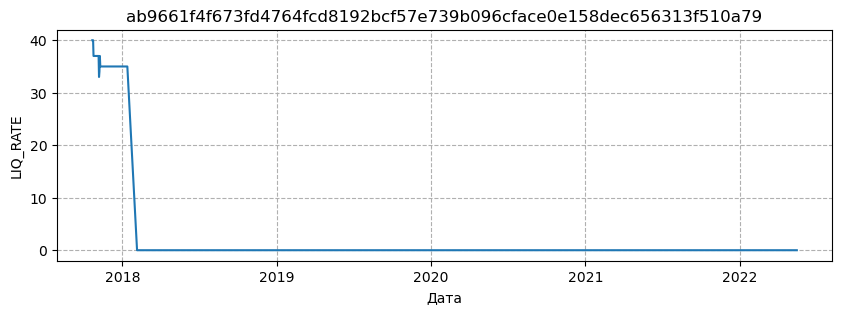

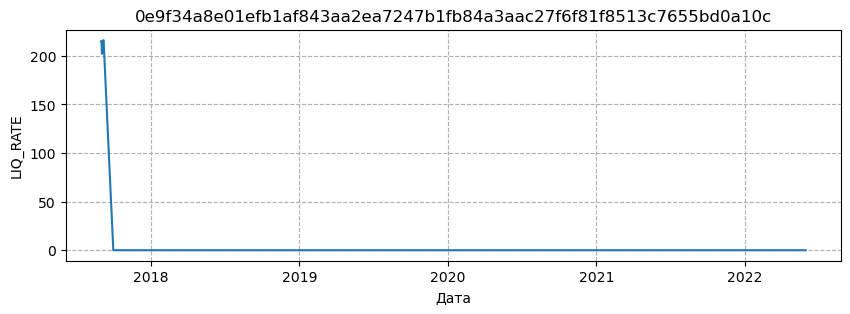

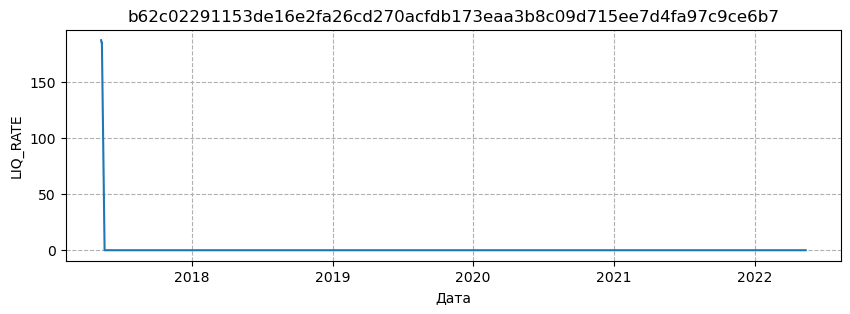

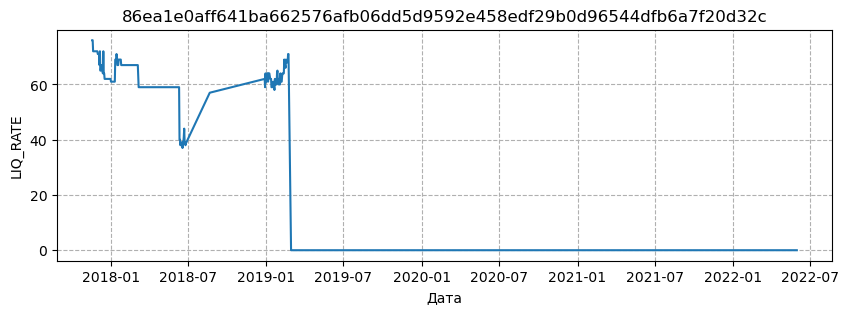

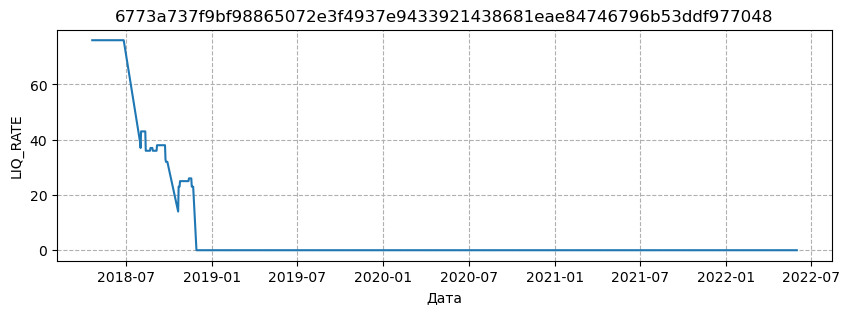

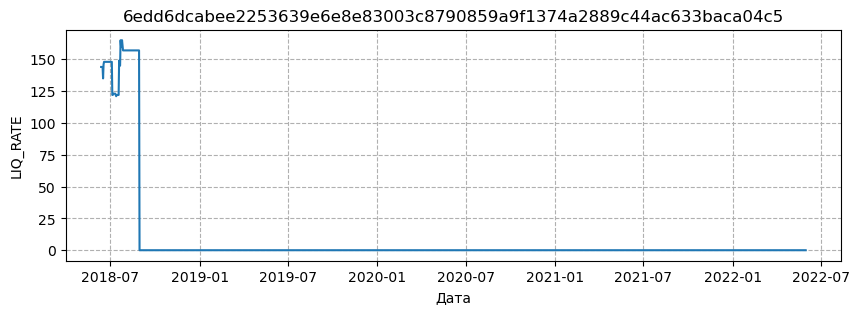

In [6]:
param = "LIQ_RATE"

for well in data[(data["CHARWORK"] == "P")]["WELL_NAME"].unique()[:10]:
    tmp = data[data["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

In [7]:
grouped_df = data.groupby(["WELL_NAME"], as_index=True).agg({"CHARWORK": ["unique"]})
grouped_df.columns = ["_".join(x).rstrip("_") for x in grouped_df.columns.ravel()]
grouped_df["CHARWORK_unique"] = [
    ",".join(map(str, l)) for l in grouped_df["CHARWORK_unique"]
]
only_one_role = grouped_df[grouped_df["CHARWORK_unique"].astype("str").str.len() == 1]
one_role_list = only_one_role.index.tolist()
only_one_role.CHARWORK_unique.value_counts()

CHARWORK_unique
P    205
I      9
Name: count, dtype: int64

In [8]:
data_filtered = data[data["WELL_NAME"].isin(one_role_list)]
data_filtered

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,LIQ_RATE,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,IS_WORKING
0,2017-02-01,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
1,2017-02-02,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
2,2017-02-03,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
3,2017-02-04,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
4,2017-02-05,9e4912342a7d40c2a7bcd2f62852ad91ea0923333d0f55...,I,0.0,0.0,NaN,225.0,150.0,True
...,...,...,...,...,...,...,...,...,...
177570,2022-05-27,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177571,2022-05-28,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177572,2022-05-29,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True
177573,2022-05-30,1de41569155b66df7355c8fc7a53e80333aea79dc9bb37...,P,328.0,70.0,60.73,0.0,NaN,True


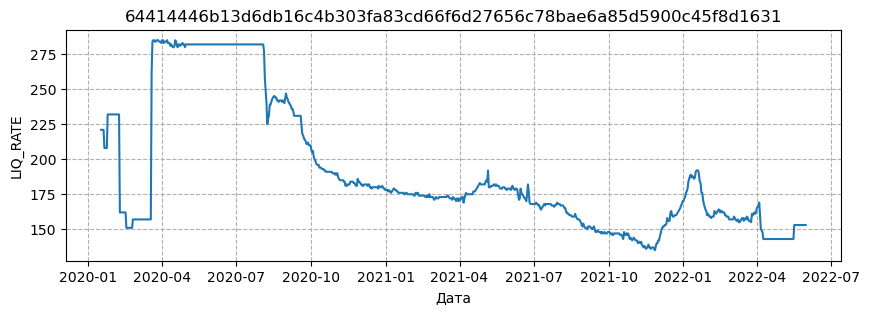

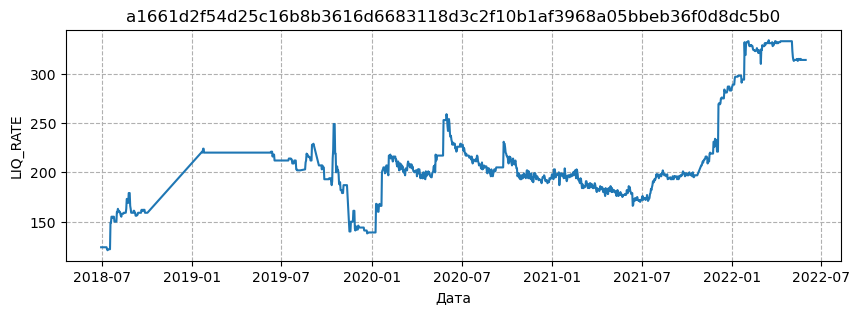

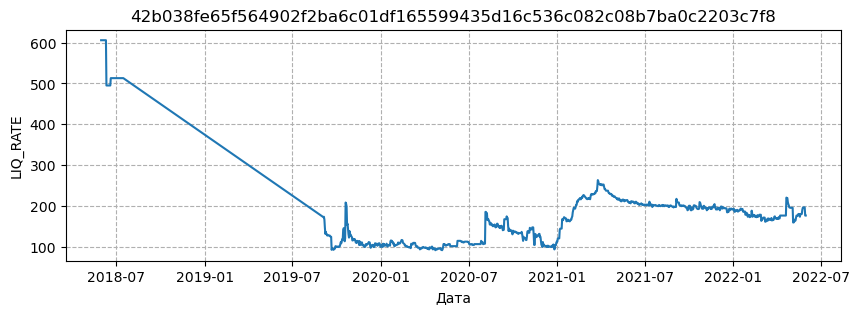

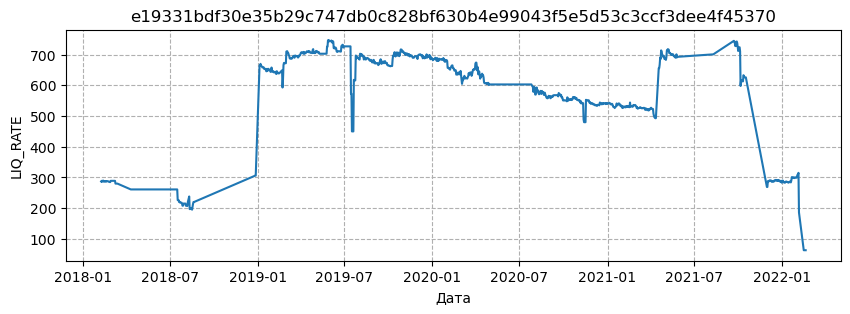

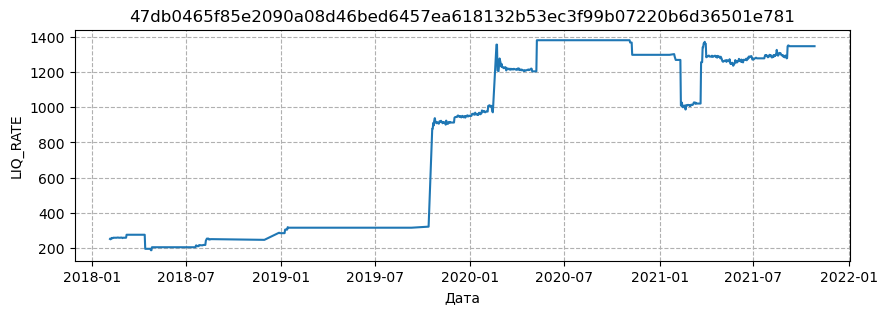

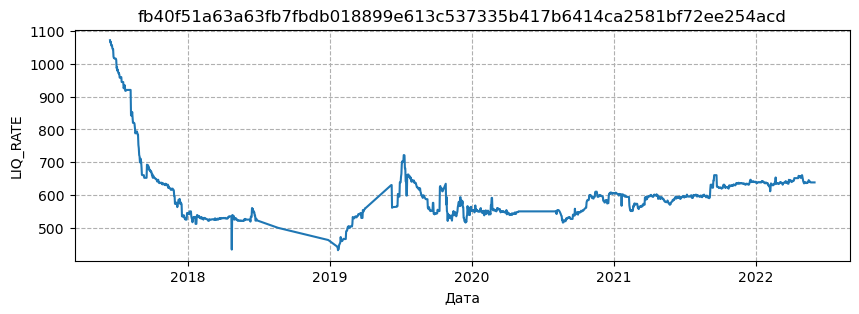

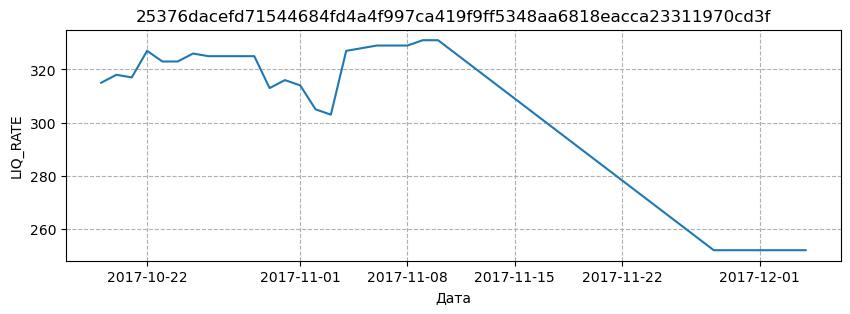

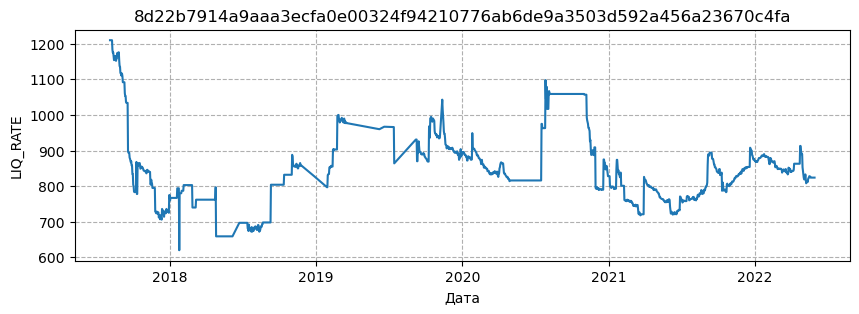

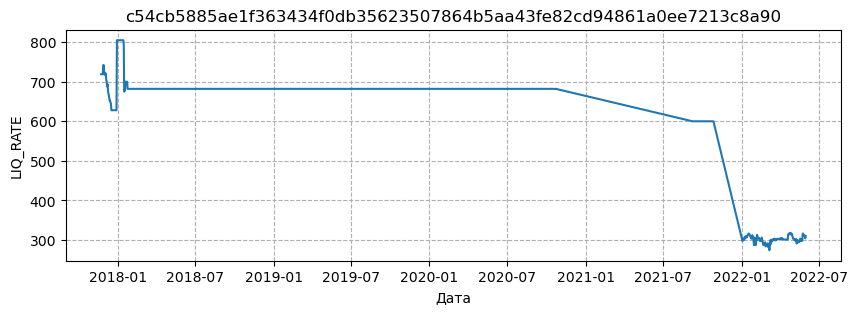

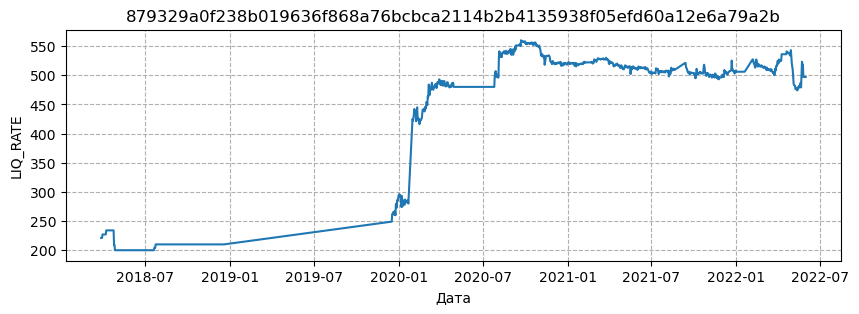

In [9]:
param = "LIQ_RATE"

for well in data_filtered[(data_filtered["CHARWORK"] == "P")]["WELL_NAME"].unique()[:10]:
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

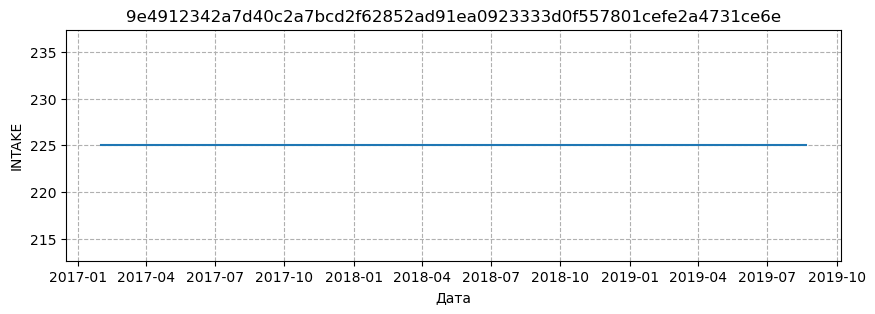

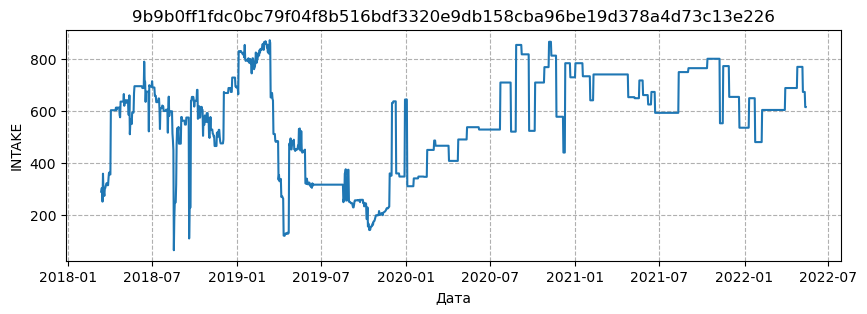

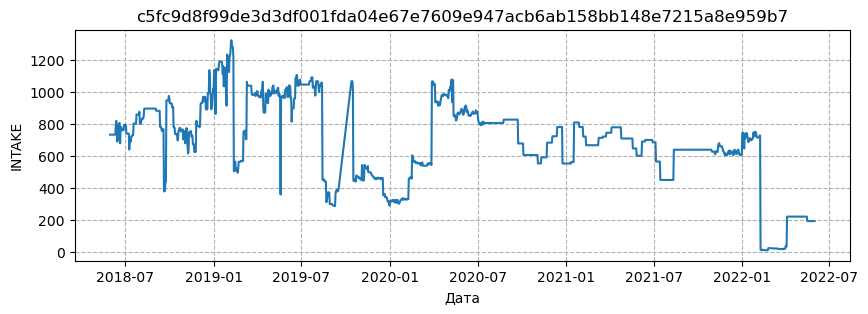

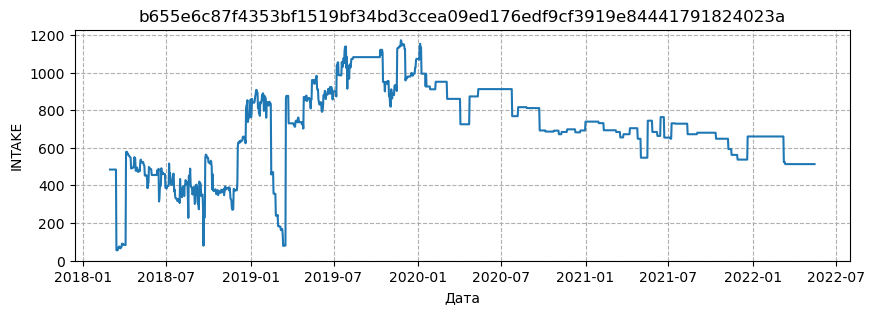

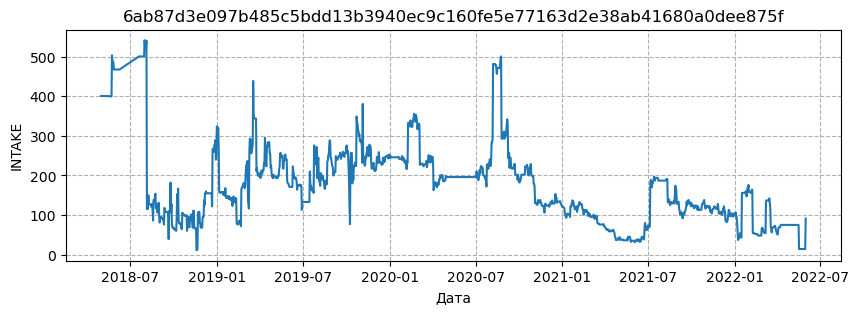

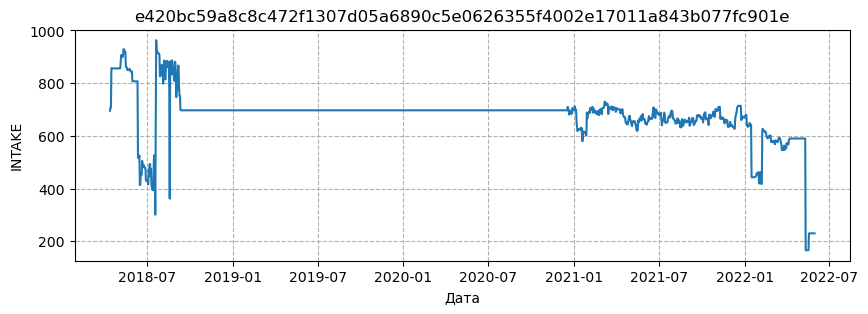

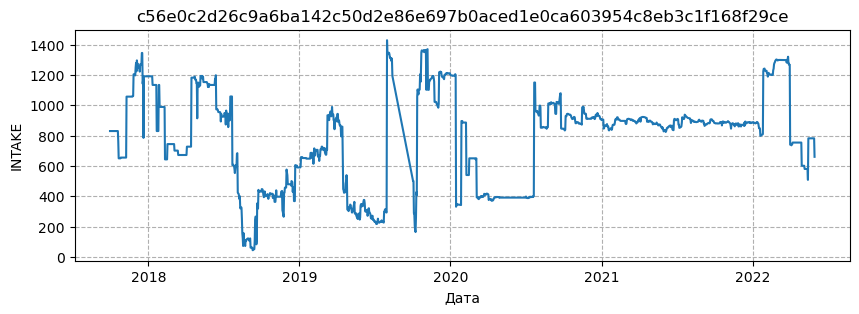

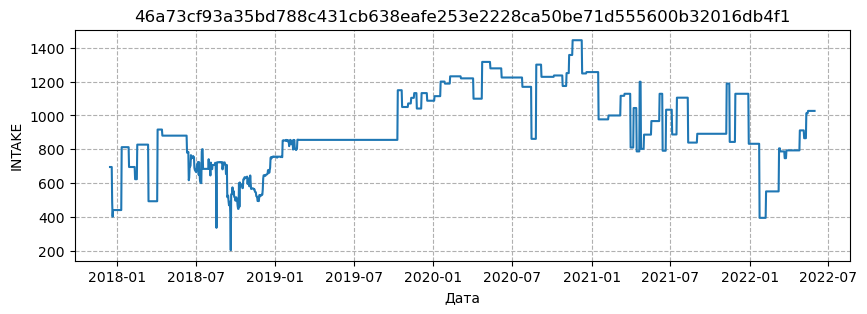

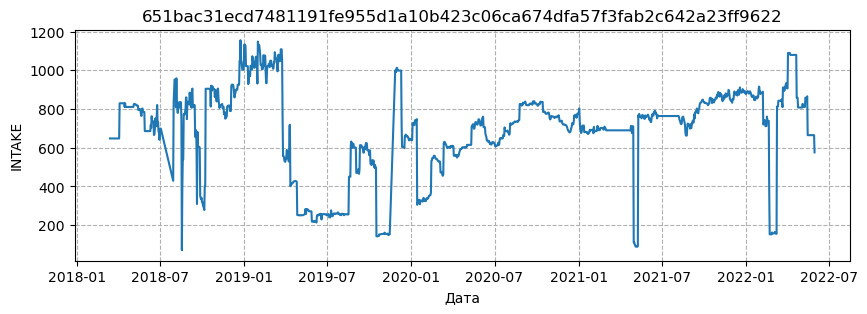

In [10]:
param = "INTAKE"

for well in data_filtered[(data_filtered["CHARWORK"] == "I")]["WELL_NAME"].unique()[:10]:
    tmp = data_filtered[data_filtered["WELL_NAME"] == well]
    plt.figure(figsize=(10, 3))

    plt.plot(tmp["MEASURED_IN_DATE"], tmp[param])
    plt.grid(ls="--")
    plt.title(well)
    plt.xlabel("Дата")
    plt.ylabel(param)

In [11]:
# load coordinates
def get_coords():
    """Load coordinates from csv file."""
    df = pd.read_csv("train_test_data/coords.csv")
    print(df.shape)
    print(df["WELL_NAME"].nunique())

    return df


coords = get_coords()

# оставить только те скважины что есть в трейне
coords = coords[coords["WELL_NAME"].isin(data_filtered["WELL_NAME"].unique())]
print(coords.shape)
print(coords["WELL_NAME"].nunique())

coords = pd.merge(coords, grouped_df, on="WELL_NAME", how="left")

(424, 5)
424
(214, 5)
214


## Визуализация положения скважин

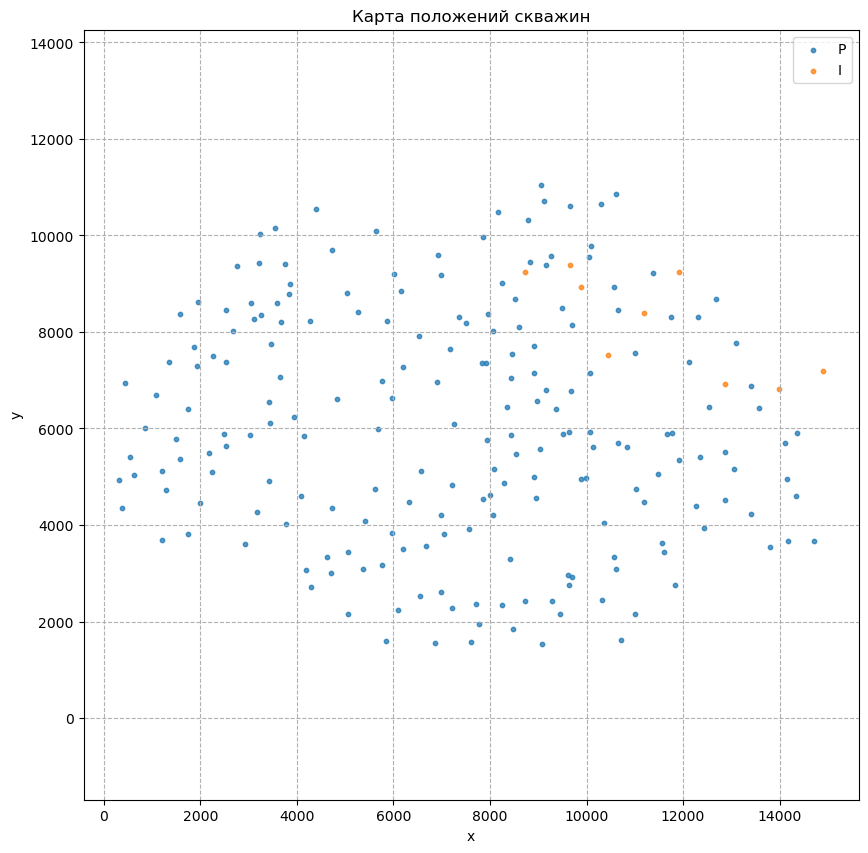

In [12]:
plt.figure(figsize=(10, 10))

for well_type in coords["CHARWORK_unique"].unique():
    tmp = coords[coords["CHARWORK_unique"] == well_type].copy()
    plt.scatter(
        tmp["COORD_X"],
        tmp["COORD_Y"],
        # label="Вход в пласт",
        label=well_type,
        s=10,
        alpha=0.75,
    )

plt.title("Карта положений скважин")
plt.axis("equal")
plt.grid(ls="--")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Подготовка данных

## Создаем числовой маппинг идентификаторов скважин для дальнейшего создаения графов.

In [13]:
p_wells = data_filtered[data_filtered.loc[:, "CHARWORK"] == 'P'].sort_values("MEASURED_IN_DATE")["WELL_NAME"].unique()
i_wells = data_filtered[data_filtered.loc[:, "CHARWORK"] == 'I'].sort_values("MEASURED_IN_DATE")["WELL_NAME"].unique()

p_coords = coords[coords["WELL_NAME"].isin(p_wells)]
i_coords = coords[coords["WELL_NAME"].isin(i_wells)]

In [14]:
new_p_ids = list(range(len(p_wells)))
new_i_ids = list(range(len(i_wells)))

p_mapping = dict(zip(p_wells, new_p_ids))
i_mapping = dict(zip(i_wells, new_i_ids))
p_mapping_inv = dict(zip(new_p_ids, p_wells))
i_mapping_inv = dict(zip(new_i_ids, i_wells))
mapping = {**p_mapping, **i_mapping}

data_filtered.loc[:, "WELL_NAME"] = data_filtered["WELL_NAME"].map(mapping)

p_coords.loc[:, "WELL_NAME"] = p_coords["WELL_NAME"].map(p_mapping)
i_coords.loc[:, "WELL_NAME"] = i_coords["WELL_NAME"].map(i_mapping)

## Оставляем только интересующие нас признаки 

In [15]:
data_filtered.columns

Index(['MEASURED_IN_DATE', 'WELL_NAME', 'CHARWORK', 'LIQ_RATE', 'WATER_CUT',
       'P_ZAB', 'INTAKE', 'WELLHEAD_PRESSURE', 'IS_WORKING'],
      dtype='object')

In [16]:
col_to_drop = [
    "WATER_CUT",
    "P_ZAB",
    "INTAKE",
    "WELLHEAD_PRESSURE",
    "IS_WORKING",
    "CHARWORK"
]

data_prod = data_filtered[data_filtered["CHARWORK"] == "P"].drop(col_to_drop, axis=1)
print(data_prod.shape)
data_prod.isnull().sum()

(115244, 3)


MEASURED_IN_DATE    0
WELL_NAME           0
LIQ_RATE            0
dtype: int64

In [17]:
col_to_drop_1 = [
    "WATER_CUT",
    "P_ZAB",
    "LIQ_RATE",
    "WELLHEAD_PRESSURE",
    "IS_WORKING",
    "CHARWORK"
]

data_inj = data_filtered[data_filtered["CHARWORK"] == "I"].drop(col_to_drop_1, axis=1)
print(data_inj.shape)
data_inj.isnull().sum()

(11358, 3)


MEASURED_IN_DATE    0
WELL_NAME           0
INTAKE              0
dtype: int64

In [18]:
data_prod.describe()

,MEASURED_IN_DATE,LIQ_RATE
count,115244,115244.000000
mean,2021-01-10 21:11:15.117142784,339.798766
min,2016-08-02 00:00:00,1.000000
25%,2020-08-12 00:00:00,115.000000
50%,2021-05-13 00:00:00,235.000000
75%,2021-11-18 00:00:00,492.000000
max,2022-05-31 00:00:00,1622.000000
std,NaN,298.642642


In [19]:
data_inj.describe()

,MEASURED_IN_DATE,INTAKE
count,11358,11358.000000
mean,2020-02-19 19:24:37.654516480,618.961789
min,2017-02-01 00:00:00,10.000000
25%,2018-12-20 00:00:00,319.000000
50%,2020-03-02 12:00:00,663.000000
75%,2021-04-25 00:00:00,852.000000
max,2022-05-31 00:00:00,1444.000000
std,NaN,317.981496


## Заполнение пропусков

In [20]:
days_prod = data_prod['MEASURED_IN_DATE'].unique().tolist()
days_inj = data_inj['MEASURED_IN_DATE'].unique().tolist()
print(f"production days: {len(days_prod)}")
print(f"injection days: {len(days_inj)}")

production days: 2122
injection days: 1932


In [21]:
data_prod_sorted = data_prod.sort_values('MEASURED_IN_DATE').set_index('MEASURED_IN_DATE')
data_inj_sorted = data_inj.sort_values('MEASURED_IN_DATE').set_index('MEASURED_IN_DATE')

In [22]:
def fill_gaps(df):
    cols = df.select_dtypes(include='number').columns
    wells = df["WELL_NAME"].unique().tolist()
    result_df = pd.DataFrame()
    for well in wells:
        tmp = df[df["WELL_NAME"] == well].copy()
        # Создаем полный диапазон дат
        full_date_range = pd.date_range(start=tmp.index.min(), end=tmp.index.max(), freq='D')
        # Создаем новый датафрейм с полным диапазоном дат
        tmp = tmp.reindex(full_date_range)
        for col in cols:
            tmp[col] = tmp[col].resample('1D').interpolate()
        tmp['WELL_NAME'] = well
        result_df = pd.concat([result_df, tmp])
    return result_df

In [23]:
data_prod_filled = fill_gaps(data_prod_sorted)

In [24]:
data_prod_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115244 entries, 2016-08-02 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  115244 non-null  object 
 1   LIQ_RATE   115244 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.6+ MB


In [25]:
data_prod_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141782 entries, 2016-08-02 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  141782 non-null  int64  
 1   LIQ_RATE   141782 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.2 MB


In [26]:
data_inj_filled = fill_gaps(data_inj_sorted)

In [27]:
data_inj_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11358 entries, 2017-02-01 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NAME  11358 non-null  object 
 1   INTAKE     11358 non-null  float64
dtypes: float64(1), object(1)
memory usage: 266.2+ KB


In [28]:
data_inj_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13334 entries, 2017-02-01 to 2022-05-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NAME  13334 non-null  int64  
 1   INTAKE     13334 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.5 KB


In [29]:
days_prod = data_prod_filled.index.unique().tolist()
days_inj = data_inj_filled.index.unique().tolist()
print(f"production days: {len(days_prod)}")
print(f"injection days: {len(days_inj)}")

production days: 2129
injection days: 1946


In [30]:
overlapping_dates = sorted(list(set(days_prod).intersection(set(days_inj))))

In [31]:
len(overlapping_dates)

1946

In [32]:
overlapping_dates[:3]

[Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-02-02 00:00:00'),
 Timestamp('2017-02-03 00:00:00')]

In [33]:
data_prod_overlap = data_prod_filled.loc[overlapping_dates, :]
data_inj_overlap = data_inj_filled.loc[overlapping_dates, :]

## Объединение данных с координатами

In [34]:
data_prod_final = data_prod_overlap.reset_index().merge(p_coords.drop(["X2", "Y2", "CHARWORK_unique"], axis=1), on="WELL_NAME").set_index("index")
data_inj_final = data_inj_overlap.reset_index().merge(i_coords.drop(["X2", "Y2", "CHARWORK_unique"], axis=1), on="WELL_NAME").set_index("index")

In [35]:
data_prod_final.head()

,WELL_NAME,LIQ_RATE,COORD_X,COORD_Y
index,,,,
2017-02-01,0,705.0,9485.72,8494.28
2017-02-01,1,579.0,9704.72,8153.28
2017-02-01,2,889.0,10075.72,7153.28
2017-02-01,3,1120.0,10660.72,8462.28
2017-02-01,4,453.0,12260.72,4397.28


In [36]:
data_inj_final.head()

,WELL_NAME,INTAKE,COORD_X,COORD_Y
index,,,,
2017-02-01,0,225.0,8723.72,9233.28
2017-02-02,0,225.0,8723.72,9233.28
2017-02-03,0,225.0,8723.72,9233.28
2017-02-04,0,225.0,8723.72,9233.28
2017-02-05,0,225.0,8723.72,9233.28


## Проверка консистентности дат

In [37]:
# Функция для проверки порядка и пропусков
def check_dates_sequential_and_no_gaps(df, df_name):
    # Получаем уникальные даты и сортируем их
    unique_dates = df.index.drop_duplicates().sort_values()
    
    # Проверка, что уникальные даты отсортированы по возрастанию
    is_sorted = unique_dates.is_monotonic_increasing
    if not is_sorted:
        print(f"Уникальные даты в датафрейме {df_name} не отсортированы по возрастанию.")
        return Falsed

    # Проверка на пропуски
    date_diff = unique_dates.to_series().diff().dropna()
    if not (date_diff == date_diff.iloc[0]).all():
        print(f"В датафрейме {df_name} есть пропуски в датах.")
        return False

    print(f"Даты в датафрейме {df_name} идут по порядку и не имеют пропусков.")
    return True

# Проверка для обоих датафреймов
check_dates_sequential_and_no_gaps(data_prod_final, "prod")
check_dates_sequential_and_no_gaps(data_inj_final, "inj")

Даты в датафрейме prod идут по порядку и не имеют пропусков.
Даты в датафрейме inj идут по порядку и не имеют пропусков.


True

In [38]:
list(data_inj_final.index.unique()) == list(data_prod_final.index.unique())

True

## Визуализация профилей для подготовленных данных

In [39]:
column = "LIQ_RATE"

data = data_prod_final.pivot_table(index=data_prod_final.index, columns="WELL_NAME", values=column)

data.head()

WELL_NAME,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
index,,,,,,,,,,,,,,,,,,,,,
2017-02-01,705.0,579.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-04,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05,684.0,560.0,889.0,1120.0,453.0,347.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


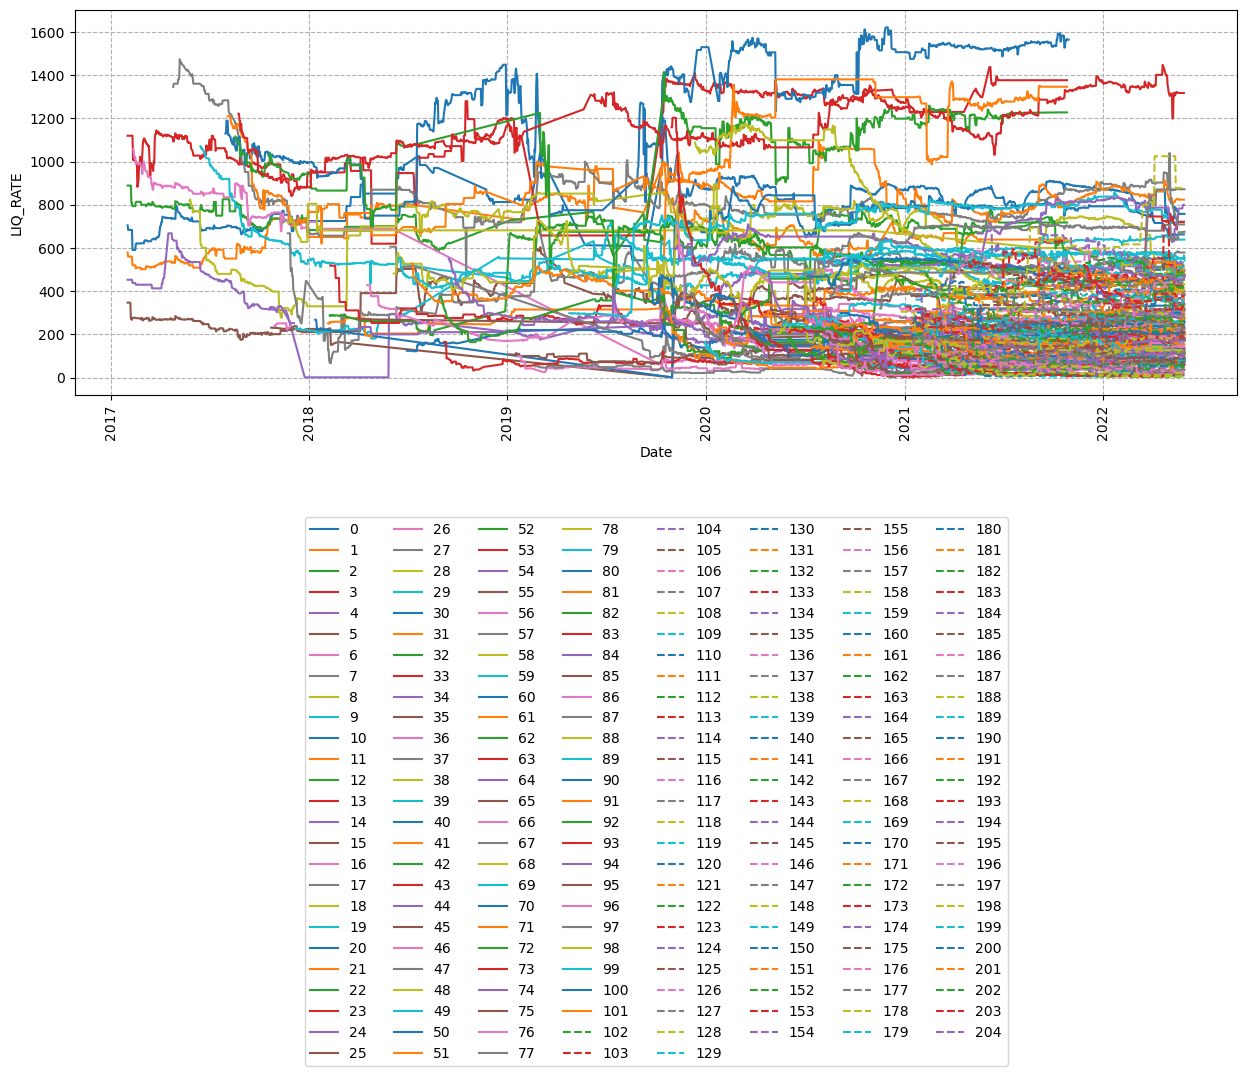

In [40]:
# Define a list of line styles for the plot
ls = ["-"] * (len(data.columns) // 2) + ["--"] * (len(data.columns) // 2 + 1)

plt.figure(figsize=(15, 5))

# Loop over each column in the dataframe
for i, col in enumerate(data.columns):
    # For each column, plot the data with the corresponding line style
    plt.plot(data[col], label=col, ls=ls[i])

# Add a legend to the plot, located at the upper center outside the plot area
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

# Add a grid to the plot with a dashed line style
plt.grid(ls="--")

plt.xlabel("Date")
plt.ylabel(column)
plt.xticks(rotation=90)
plt.show()

In [41]:
column = "INTAKE"

data = data_inj_final.pivot_table(index=data_inj_final.index, columns="WELL_NAME", values=column)

data.head()

WELL_NAME,0,1,2,3,4,5,6,7,8
index,,,,,,,,,
2017-02-01,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-04,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


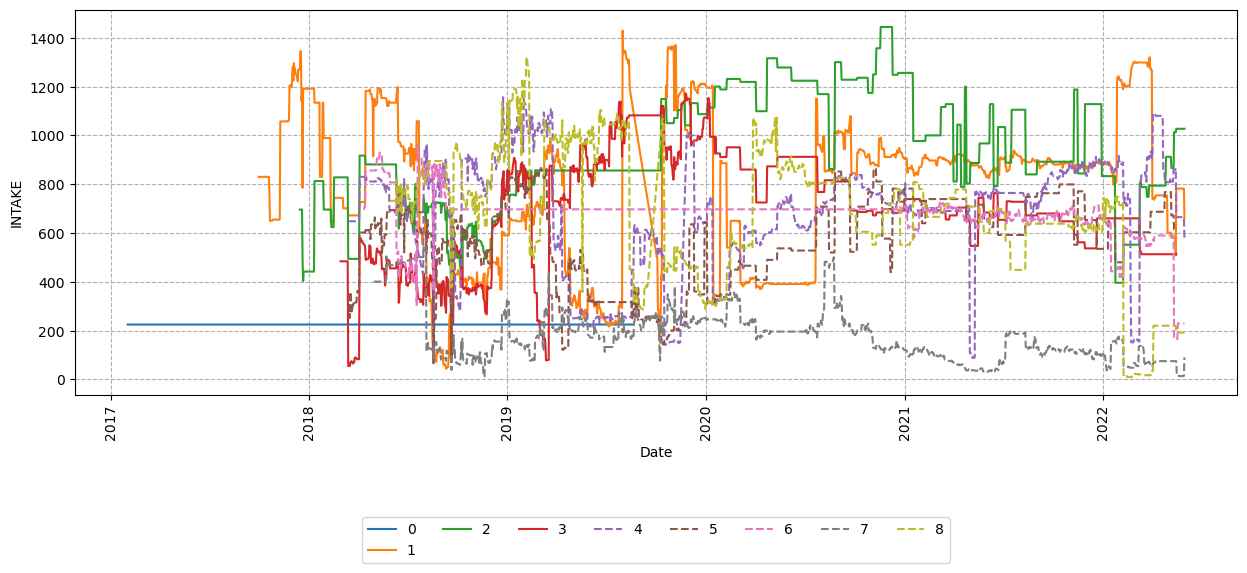

In [42]:
# Define a list of line styles for the plot
ls = ["-"] * (len(data.columns) // 2) + ["--"] * (len(data.columns) // 2 + 1)

plt.figure(figsize=(15, 5))

# Loop over each column in the dataframe
for i, col in enumerate(data.columns):
    # For each column, plot the data with the corresponding line style
    plt.plot(data[col], label=col, ls=ls[i])

# Add a legend to the plot, located at the upper center outside the plot area
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

# Add a grid to the plot with a dashed line style
plt.grid(ls="--")

plt.xlabel("Date")
plt.ylabel(column)
plt.xticks(rotation=90)
plt.show()

# Масштабирование подготовленных данных

In [43]:
scaler_target = StandardScaler()
scaler_water = StandardScaler()

data_prod_final_scaled = data_prod_final.copy()
data_inj_final_scaled = data_inj_final.copy()

data_prod_final_scaled.loc[:, ["LIQ_RATE"]] = scaler_target.fit_transform(data_prod_final_scaled.loc[:, ["LIQ_RATE"]])
data_inj_final_scaled.loc[:, ["INTAKE"]] = scaler_water.fit_transform(data_inj_final_scaled.loc[:, ["INTAKE"]])

In [44]:
scaler_target.mean_, scaler_target.scale_

(array([348.26628499]), array([300.43978432]))

## Сохранение скейлера

In [47]:
joblib.dump(scaler_target, "scaler_prod.save")
joblib.dump(scaler_water, "scaler_inj.save")

['scaler_inj.save']

# Создание последовательностей гетерогенных графов

In [45]:
NUM_PROD_WELLS = len(p_wells)
NUM_INJ_WELLS = len(i_wells)

# num_prod_feat = data_prod_final_scaled.shape[1] - 3
# num_inj_feat = data_inj_final_scaled.shape[1] - 3

# В нашем случае количество признаков можно задать явно
num_prod_feat = 1
num_inj_feat = 1

In [48]:
edge_indexes_dicts = []
edge_weights_dicts = []

days = data_prod_final_scaled.index.unique()

for day in days:
    inj_prod_edges = []
    prod_prod_edges = []
    inj_inj_edges=[]

    inj_prod_weights = []
    prod_prod_weights = []
    inj_inj_weights = []

    tmp_prod = data_prod_final_scaled.loc[day, :]
    tmp_inj = data_inj_final_scaled.loc[day, :]

    if isinstance(tmp_inj, pd.Series):
        for _, prod_well in tmp_prod.iterrows():
            distance = np.sqrt((tmp_inj["COORD_X"] - prod_well["COORD_X"])**2\
                                + (tmp_inj["COORD_Y"] - prod_well["COORD_Y"])**2)
            if distance < 1000:
                inj_prod_edges.append([tmp_inj["WELL_NAME"], prod_well["WELL_NAME"]])
                inj_prod_weights.append(distance)

        for _, prod_well_1 in tmp_prod.iterrows():
            for _, prod_well_2 in tmp_prod.iterrows():
                distance = np.sqrt((prod_well_1['COORD_X'] - prod_well_2['COORD_X'])**2\
                                   + (prod_well_1['COORD_Y'] - prod_well_2['COORD_Y'])**2)
                if distance < 1000 and prod_well_1["WELL_NAME"] != prod_well_2["WELL_NAME"]:
                    prod_prod_edges.append([prod_well_1["WELL_NAME"], prod_well_2["WELL_NAME"]])
                    prod_prod_weights.append(distance)
        
    else:
        for _, inj_well in tmp_inj.iterrows():
            for _, prod_well in tmp_prod.iterrows():
                distance = np.sqrt((inj_well["COORD_X"] - prod_well["COORD_X"])**2\
                                   + (inj_well["COORD_Y"] - prod_well["COORD_Y"])**2)
                if distance < 1000:
                    inj_prod_edges.append([inj_well["WELL_NAME"], prod_well["WELL_NAME"]])
                    inj_prod_weights.append(distance)

        for _, prod_well_1 in tmp_prod.iterrows():
            for _, prod_well_2 in tmp_prod.iterrows():
                distance = np.sqrt((prod_well_1['COORD_X'] - prod_well_2['COORD_X'])**2\
                                   + (prod_well_1['COORD_Y'] - prod_well_2['COORD_Y'])**2)
                if distance < 1000 and prod_well_1["WELL_NAME"] != prod_well_2["WELL_NAME"]:
                    prod_prod_edges.append([prod_well_1["WELL_NAME"], prod_well_2["WELL_NAME"]])
                    prod_prod_weights.append(distance)
    
        for _, inj_well_1 in tmp_inj.iterrows():
            for _, inj_well_2 in tmp_inj.iterrows():
                distance = np.sqrt((inj_well_1['COORD_X'] - inj_well_2['COORD_X'])**2\
                                   + (inj_well_1['COORD_Y'] - inj_well_2['COORD_Y'])**2)
                if distance < 1000 and inj_well_1["WELL_NAME"] != inj_well_2["WELL_NAME"]:
                    inj_inj_edges.append([inj_well_1["WELL_NAME"], inj_well_2["WELL_NAME"]])
                    inj_inj_weights.append(distance)
        
    edge_dict = {
        ("inj", "-", "prod"): torch.tensor(inj_prod_edges, dtype=torch.long).t().contiguous() if len(inj_prod_edges) != 0 else torch.tensor([[], []], dtype=torch.long),
        ("prod", "-", "prod"): torch.tensor(prod_prod_edges, dtype=torch.long).t().contiguous() if len(prod_prod_edges) != 0 else torch.tensor([[], []], dtype=torch.long),
        ("inj", "-", "inj"): torch.tensor(inj_inj_edges, dtype=torch.long).t().contiguous() if len(inj_inj_edges) != 0 else torch.tensor([[], []], dtype=torch.long)
    }
    edge_weights_dict = {
        ("inj", "-", "prod"): torch.tensor(inj_prod_weights, dtype=torch.float),
        ("prod", "-", "prod"): torch.tensor(prod_prod_weights, dtype=torch.float),
        ("inj", "-", "inj"): torch.tensor(inj_inj_weights, dtype=torch.float)
    }
    edge_indexes_dicts.append(edge_dict)
    edge_weights_dicts.append(edge_weights_dict)

In [50]:
node_feat_dicts = []
target_dicts = []
work_hours_dicts = []
choke_sizes_dicts = []

for day in days:
    prod_features = np.zeros(shape=(NUM_PROD_WELLS, num_prod_feat))
    inj_features = np.zeros(shape=(NUM_INJ_WELLS, num_inj_feat))
    target = np.zeros(shape=(NUM_PROD_WELLS, 1))

    tmp_prod = data_prod_final_scaled.loc[day, :]
    tmp_inj = data_inj_final_scaled.loc[day, :]

    for _, prod_well in tmp_prod.iterrows():
        i = int(prod_well["WELL_NAME"])
        prod_features[i, :] = prod_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values

    if isinstance(tmp_inj, pd.Series):
        i = int(inj_well["WELL_NAME"])
        inj_features[i, :] = inj_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values
    else:
        for _, inj_well in tmp_inj.iterrows():
            i = int(inj_well["WELL_NAME"])
            inj_features[i, :] = inj_well.drop(["COORD_X", "COORD_Y", "WELL_NAME"], axis=0).values

    for _, prod_well in tmp_prod.iterrows():
        i = int(prod_well["WELL_NAME"])
        target[i] = prod_well['LIQ_RATE']

    feat_dict = {
        "prod": torch.tensor(prod_features, dtype=torch.float),
        "inj": torch.tensor(inj_features, dtype=torch.float)
        }
    target_dict = {"prod": torch.tensor(target, dtype=torch.float)}
    
    node_feat_dicts.append(feat_dict)
    target_dicts.append(target_dict)

In [52]:
print(len(edge_weights_dicts), len(node_feat_dicts))

1946 1946


In [53]:
dataset= DynamicHeteroGraphTemporalSignal(
    edge_index_dicts=edge_indexes_dicts,
    edge_weight_dicts=edge_weights_dicts,
    feature_dicts=node_feat_dicts,
    target_dicts=target_dicts,
)

## Сохраняем объект датасета для дальнейшего использования

In [149]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)

In [4]:
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)